# 5. Optimisation des stocks

## Importation des bibliothèques

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Charte graphique

In [20]:
# Couleurs principales
MINI_BLUE = '#607D8B'    
MINI_GREEN = '#A5D6A7'   
MINI_GRAY = '#9E9E9E'    

MANDARINE = '#FF9800'    
SOFT_ORANGE = '#FFC107'  
BLEU_CANARD = '#00796B'     
WINE = '#880E4F'  

# fond et lignes de structure
LIGHT_GRID = '#EDEDED' 
BG_WHITE = '#FFFFFF'     
LIGHT_GRAY = '#BDBDBD'

def set_minimalist_style():
    """Applique le style graphique 'Minimaliste 2025' pour la clarté."""
    
    # 1. Utiliser le thème 'white' de Seaborn
    sns.set_theme(style="white") 
    
    # Définir la nouvelle séquence de couleurs complète (7 couleurs)
    FULL_COLOR_CYCLE = [
        MINI_BLUE,
        MINI_GREEN,
        MINI_GRAY,
        MANDARINE, 
        SOFT_ORANGE, 
        BLEU_CANARD,
        WINE
    ]
    
    # 2. Modifier les paramètres globaux (rcParams)
    plt.rcParams.update({
        
        # --- FOND ET CADRE ---
        'figure.facecolor': BG_WHITE,
        'axes.facecolor': BG_WHITE,
        'axes.edgecolor': LIGHT_GRAY, 
        'axes.linewidth': 0.5,
        
        # --- GRILLE ---
        'axes.grid': True,
        'grid.color': LIGHT_GRID,
        'grid.linestyle': '-',
        'grid.linewidth': 0.7,
        
        # --- TYPOGRAPHIE ET LABELS ---
        'font.family': 'sans-serif',
        'axes.titlesize': 18,
        'axes.labelsize': 11,
        'legend.frameon': False,
        
        # --- LIGNES ET PALETTE ---
        'lines.linewidth': 1.8,
        # Définition du cycle de 7 couleurs pour Matplotlib
        'axes.prop_cycle': plt.cycler('color', FULL_COLOR_CYCLE) 
    })
    
    # 3. Appliquer également la palette de 7 couleurs à Seaborn
    sns.set_palette(FULL_COLOR_CYCLE)

set_minimalist_style()

## 5.a. Stock Cover

### Importation des données

In [44]:
df_autonomie = pd.read_csv(r"../1.Donnees\3.Exports_csv\3.analyse_produits\3.2.produits_stratégiques\3.2.3.a.nb_semaines_autonomie.csv").copy()

df_stock_actuel = pd.read_csv(r"../1.Donnees\1.Generation_donnees_python\stock_actuel.csv").copy()

### Préparation des données

In [22]:
# Suppression des colonnes inutiles dans le Data Frame df_autonomie :

df_autonomie.drop(columns =['stock_categorie', 'pct_volume_categorie', 'cycle_reapprovisionnement_semaines', 'stock_reference'], inplace = True)

In [23]:
# --- Calcul de l'Autonomie des Stocks (Stock Cover en Semaines) ---

# Le but de l'analyse est de calculer le 'Stock Cover' (autonomie des stocks) en semaines pour chaque catégorie de produits.
# Cet indicateur est crucial pour évaluer le risque de rupture de stock ou de surstock.

# Jointure du DataFrame des stocks actuels ('df_stock_actuel') avec le DataFrame d'autonomie ('df_autonomie')
# sur la clé unique 'reference_produit' pour associer l'état du stock à la demande moyenne.
df_stock_cover = pd.merge(df_stock_actuel, df_autonomie, on='reference_produit', how='inner')

# Nettoyage des colonnes : Suppression de la colonne catégorie redondante ('categorie_y') après la jointure.
df_stock_cover.drop(columns='categorie_y', inplace=True)

# Création de la colonne 'stock_cover_semaines'.
# Formule analytique : Stock Actuel / Volume Vendu par Semaine.
# Le résultat indique combien de semaines le stock actuel peut couvrir la demande moyenne observée.
df_stock_cover['stock_cover_semaines'] = df_stock_cover['stock_actuel'] / df_stock_cover['volume_vendu_semaine'] 

# Agrégation par catégorie : Calcul de la moyenne du Stock Cover par catégorie.
# Cette étape fournit une mesure synthétique de l'autonomie au niveau du groupe de produits.
df_stock_cover = df_stock_cover.groupby('categorie_x')['stock_cover_semaines'].mean().reset_index()

# Renommage de la colonne de catégorie agrégée pour plus de clarté.
df_stock_cover['categorie'] = df_stock_cover['categorie_x']

# Finalisation du DataFrame en supprimant l'ancienne colonne de catégorie.
df_stock_cover.drop(columns='categorie_x', inplace=True)

# Définition de l'index sur la colonne 'categorie' pour faciliter la lecture et l'intégration dans les visualisations.
df_stock_cover.set_index('categorie', inplace=True)

# Affichage du DataFrame final contenant le Stock Cover moyen par catégorie.
df_stock_cover

,stock_cover_semaines
categorie,
Ampli,2.011763
Cordes Electrique,3.873361
Cordes Folk,3.926840
Guitare Electrique,157.333518
Guitare Folk,171.430412
Mediator,3.851911
Sangle,2.062967


### Visualisation

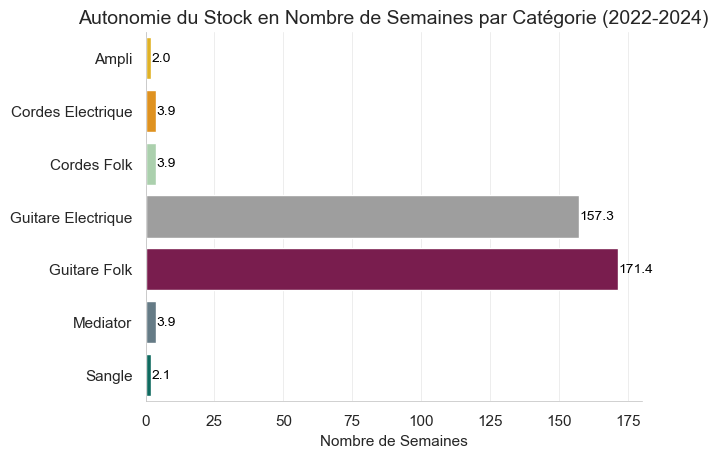

In [35]:
# --- Définition de la Palette de Couleurs ---
# Définition d'une palette personnalisée pour chaque catégorie de produit.
PALETTE_PANIER = {
    'Mediator': '#607D8B', 
    'Ampli': '#FFC107', 
    'Sangle': '#00796B', 
    'Cordes Electrique': '#FF9800', 
    'Cordes Folk': '#A5D6A7', 
    'Guitare Electrique': '#9E9E9E', 
    'Guitare Folk': '#880E4F'
}

# --- Tracé du Graphique en Barres Horizontales ---
# Génération du graphique en barres avec Seaborn. Le Stock Cover est sur l'axe X et les Catégories sur l'axe Y.
sns.barplot(
    data=df_stock_cover, 
    x='stock_cover_semaines', 
    y=df_stock_cover.index, # Utilisation de l'index (Catégories) pour l'axe Y.
    palette=PALETTE_PANIER, 
    hue=df_stock_cover.index # Utilisation de 'hue' pour appliquer la couleur par catégorie.
)

ax = plt.gca()

# --- Ajout des Étiquettes de Valeur (Annotations) ---
# Ajout de la valeur du Stock Cover (en semaines) à l'extrémité de chaque barre.
for container in ax.containers:
    for bar in container: 
        width = bar.get_width() # La largeur correspond à la valeur 'stock_cover_semaines'.
        center_y = bar.get_y() + bar.get_height() / 2.
        
        ax.text(
            width + 0.05, # Position X : légèrement à droite de la fin de la barre (+0.05).
            center_y, 
            f'{width:.1f}', # Formatage à une décimale.
            ha='left', # Alignement horizontal à gauche.
            va='center', # Alignement vertical centré sur la barre.
            fontsize=10,
            color='black'
        )

# --- Configuration des Axes et du Titre ---
plt.title('Autonomie du Stock en Nombre de Semaines par Catégorie (2022-2024)', fontsize=14)
plt.ylabel('') # Suppression de l'étiquette Y, l'index étant déjà clair.
plt.xlabel('Nombre de Semaines')

# Retrait des bordures (cadre) pour un rendu visuel plus épuré (style minimaliste).
sns.despine()

# Ajustement automatique des marges pour un affichage complet.
plt.tight_layout

plt.show()

## 5.b Analyse de l'impact des coûts de stockage sur la marge

### Importation des données

In [45]:
df_stock_immobilise= pd.read_csv(r"../1.Donnees\3.Exports_csv\3.analyse_produits\3.2.produits_stratégiques\3.2.4.stock_immobilise.csv").copy()
df_stock_immobilise

,categorie,reference_produit,stock_immobilise,cout_stock_immobilise,cout_possession_annuel
0,Guitare Folk,Martin D-18,55,105567.0,21113.4
1,Guitare Folk,Gibson L-00,69,72450.0,14490.0
2,Guitare Electrique,Duesenberg Starplayer TV,42,65494.8,13099.0
3,Guitare Folk,Taylor GS Mini,107,50076.0,10015.2
4,Guitare Folk,Yamaha FG800M,276,46202.4,9240.5
...,...,...,...,...,...
65,Sangle,Sangle cuir Deluxe,-69,-1242.0,-248.4
66,Ampli,Line 6 Catalyst 60,-8,-1291.2,-258.2
67,Ampli,Boss Katana 50 (Gen 3),-9,-1539.0,-307.8
68,Ampli,Fender Blues Junior,-4,-1845.6,-369.1


### Préparation des données 

In [47]:
# --- CALCUL DU COUT DE POSSESSION ANNUEL MOYEN EN % DU PRIX DE VENTE ---

# 1. Chargement de la table de dimension 'Produits'
df_produits = pd.read_csv(r"../1.Donnees\1.Generation_donnees_python\dim_produits.csv").copy()

# 2. Jointure du DataFrame des produits avec les données du stock immobilisé.
# L'opération 'inner merge' sur la 'reference_produit' associe les attributs financiers et le coût de possession au stock.
df_prod_couts = pd.merge(df_produits, df_stock_immobilise, on="reference_produit", how='inner')

# 3. Nettoyage des colonnes.
# Suppression des identifiants (produit_id) et des colonnes intermédiaires (poids) pour isoler les variables 
# nécessaires au calcul du coût de possession et de la marge brute unitaire.
df_prod_couts.drop(columns=['produit_id', 'cout', 'poids_categorie', 'poids_prix', 'poids_produit_final', 'categorie_y'], inplace=True)

# 4. Calcul de la valeur totale du stock immobilisé (coût de remplacement si vendu).
df_prod_couts['prix_vente_immobilise'] = df_prod_couts['prix_vente'] * df_prod_couts['stock_immobilise']

# 5. Calcul de la marge brute potentielle sur l'ensemble du stock immobilisé.
df_prod_couts['marge_brute_immobilisee'] = df_prod_couts['marge_unitaire'] * df_prod_couts['stock_immobilise']

# 6. Suppression des colonnes unitaires après le calcul des totaux immobilisés.
df_prod_couts.drop(columns=['prix_vente', 'marge_unitaire', 'cout_stock_immobilise'], inplace=True)

# 7. Calcul du KPI financier : Coût de Possession Annuel en pourcentage de la valeur totale du stock.
# Ce ratio permet de mesurer l'efficacité de la gestion des stocks en le comparant au prix de vente potentiel.
df_prod_couts['possession_%_vente'] = (df_prod_couts['cout_possession_annuel'] / df_prod_couts['prix_vente_immobilise']) * 100

# 8. Agrégation finale par catégorie.
# Utilisation de la moyenne (mean) pour obtenir les indicateurs financiers et de possession moyens par groupe de produits.
df_prod_couts_cat = df_prod_couts.groupby('categorie_x')[['cout_possession_annuel', 'possession_%_vente', 'prix_vente_immobilise', 'marge_brute_immobilisee']].mean() 

# Affichage du DataFrame final agrégé.
df_prod_couts_cat

,cout_possession_annuel,possession_%_vente,prix_vente_immobilise,marge_brute_immobilisee
categorie_x,,,,
Ampli,-249.21,11.999079,-2076.90,-830.760
Cordes Electrique,-6.89,7.981896,-86.23,-51.738
Cordes Folk,-6.34,8.035146,-78.98,-47.388
Guitare Electrique,7755.94,12.000004,64632.80,25853.120
Guitare Folk,9887.56,12.000005,82396.30,32958.520
Mediator,-7.83,8.001537,-97.89,-58.734
Sangle,-150.95,7.999849,-1886.90,-1132.140


In [27]:
# Cout de possession annuel moyen global : 
df_prod_couts['possession_%_vente'].mean()

np.float64(9.716788003816907)

### Visualisation

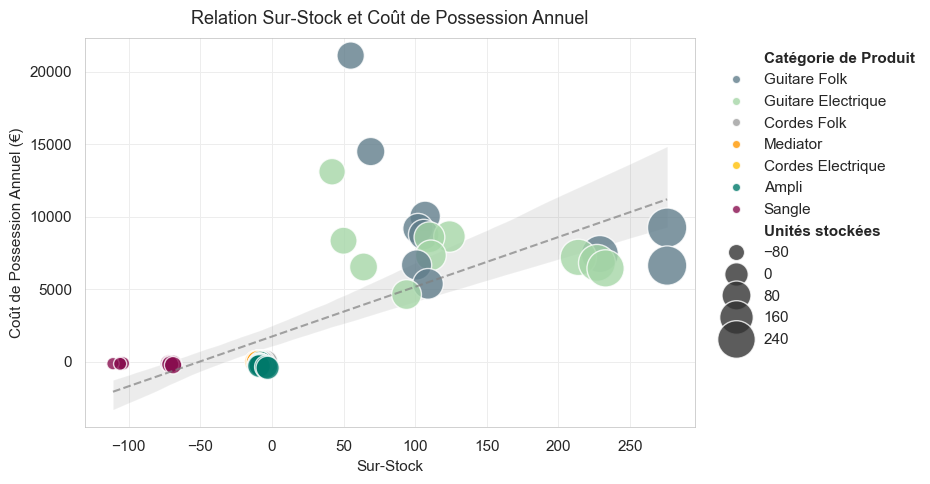

In [39]:
# --- Initialisation de la Figure et des Axes ---
plt.figure(figsize=(10, 5)) 
ax = plt.gca()

# --- Ajout de la Ligne de Régression (Tendance Linéaire) ---
# Tracé d'une droite de régression pour visualiser la tendance linéaire entre le stock immobilisé 
# (variable explicative) et le coût de possession annuel (variable expliquée).
sns.regplot(
    data=df_stock_immobilise,
    x='stock_immobilise',
    y='cout_possession_annuel',
    scatter=False, # Affiche uniquement la ligne de tendance.
    color='gray',
    line_kws={'linestyle': '--', 'linewidth': 1.5, 'alpha': 0.7}, # Mise en forme de la ligne.
    ax=ax
)

# --- Création du Nuage de Points (Scatter Plot) ---
# Visualisation de la distribution des produits. L'utilisation de 'hue' et 'size' crée un graphique à bulles 
# informatif pour analyser quatre variables simultanément (x, y, catégorie, volume).
sns.scatterplot(
    data=df_stock_immobilise,
    x='stock_immobilise',
    y='cout_possession_annuel',
    hue='categorie',# Couleur des points basée sur la Catégorie.
    size='stock_immobilise',  # Taille des points basée sur le Volume de Stock (variable quantitative).
    sizes=(80, 800), # Définition de la plage de taille des bulles.
    alpha=0.8,
    edgecolor="w", # Bordure blanche pour améliorer la distinction des bulles.
    linewidth=1,
    legend=True, 
    ax=ax 
)

# --- Configuration Avancée de la Légende ---
legend = ax.get_legend()

# Déplacement et positionnement de la légende en dehors de la zone de tracé (en haut à gauche).
legend.set_bbox_to_anchor((1.02, 1)) 
legend.set_loc('upper left')
legend.set_title('') # Suppression du titre générique de la légende.

# Mise en forme du titre de la catégorie (Hue) :
hue_title_text = legend.texts[0]
hue_title_text.set_text("Catégorie de Produit") 
hue_title_text.set_fontweight('bold')

# Mise en forme du titre du volume (Size) :
num_hue_categories = df_stock_immobilise['categorie'].nunique()
size_title_index = num_hue_categories + 1 
size_title_text = legend.texts[size_title_index]
size_title_text.set_text("Unités stockées") 
size_title_text.set_fontweight('bold')


# --- Mise en Forme Finale (Titre, Axes) ---
plt.title(
    "Relation Sur-Stock et Coût de Possession Annuel", 
    loc='center', 
    pad=10, fontsize = 13
)
ax.set_xlabel("Sur-Stock", fontsize= 11)
ax.set_ylabel("Coût de Possession Annuel (€)", fontsize= 11)

# Ajout d'une grille pour faciliter la lecture des valeurs.
plt.grid(True)
# Ajustement des marges en utilisant rect pour inclure la légende déplacée.
plt.tight_layout(rect=[0, 0, 0.95, 1]) 

plt.show()

## 5.c Stock Optimal

### Importation des données

In [46]:
df_stock_optimise = pd.read_csv(r"../1.Donnees\3.Exports_csv\3.analyse_produits\3.2.produits_stratégiques\3.2.3.a.nb_semaines_autonomie.csv").copy()
df_stock_actuel = pd.read_csv(r"../1.Donnees\1.Generation_donnees_python\stock_actuel.csv") 

In [30]:
# Calcul des stocks actuels par catégorie : 

df_stock_actuel = df_stock_actuel.groupby('categorie')['stock_actuel'].sum()
df_stock_actuel = df_stock_actuel.reset_index()

# Calcul des stocks optimaux par catégorie : 

stock_categorie= df_stock_optimise.groupby('categorie')['stock_reference'].sum()
stock_categorie = stock_categorie.reset_index('categorie')

# Jointure des deux tables pour comparer 
df_stocks_comparatifs = pd.merge(stock_categorie, df_stock_actuel, on ='categorie', how = 'inner').set_index('categorie').sort_values(by='stock_reference', ascending = True)

In [31]:
df_stocks_comparatifs = df_stocks_comparatifs.rename(columns= {'stock_reference':'Stock Recommandé', 'stock_actuel':'Stock Actuel'})

#On inverse l'ordre des colonnes : 
col_liste = df_stocks_comparatifs.columns.tolist()
col_liste[0],col_liste[1] = col_liste[1], col_liste[0]  

df_stocks_comparatifs= df_stocks_comparatifs[col_liste]
df_stocks_comparatifs

,Stock Actuel,Stock Recommandé
categorie,,
Guitare Electrique,1302,33
Guitare Folk,1467,37
Ampli,76,151
Sangle,924,1808
Cordes Folk,2056,2115
Cordes Electrique,2090,2180
Mediator,2085,2185


In [ ]:
# --- Agrégation des Stocks Actuels par Catégorie ---

# Calcul de la somme totale du 'stock_actuel' pour chaque catégorie.
df_stock_actuel = df_stock_actuel.groupby('categorie')['stock_actuel'].sum()
# Réinitialisation de l'index pour transformer 'categorie' d'index en colonne.
df_stock_actuel = df_stock_actuel.reset_index()

# --- Agrégation des Stocks Optimaux (Référence) par Catégorie ---

# Calcul de la somme totale du 'stock_reference' (stock optimal) pour chaque catégorie.
stock_categorie = df_stock_optimise.groupby('categorie')['stock_reference'].sum()
# Réinitialisation de l'index pour permettre la jointure.
stock_categorie = stock_categorie.reset_index('categorie')

# --- Jointure et Préparation du DataFrame Comparatif ---

# Jointure des deux DataFrames agrégés sur la colonne 'categorie'.
# L'opération 'inner join' garantit que seules les catégories présentes dans les deux jeux de données sont conservées.
df_stocks_comparatifs = pd.merge(stock_categorie, df_stock_actuel, on='categorie', how='inner')
# Définition de l'index sur 'categorie' et tri par ordre croissant du stock recommandé pour la visualisation.
df_stocks_comparatifs = df_stocks_comparatifs.set_index('categorie').sort_values(by='stock_reference', ascending=True)

# Renommage explicite des colonnes pour une meilleure lisibilité dans le résultat final.
df_stocks_comparatifs = df_stocks_comparatifs.rename(columns={'stock_reference': 'Stock Recommandé', 'stock_actuel': 'Stock Actuel'})

# --- Inversion de l'Ordre des Colonnes ---

# Récupération de l'ordre actuel des colonnes.
col_liste = df_stocks_comparatifs.columns.tolist()
# Inversion positionnelle des deux premières colonnes.
col_liste[0], col_liste[1] = col_liste[1], col_liste[0]

# Application du nouvel ordre au DataFrame.
df_stocks_comparatifs = df_stocks_comparatifs[col_liste]

# Affichage du tableau comparatif final.
df_stocks_comparatifs

,Stock Actuel,Stock Recommandé
categorie,,
Guitare Electrique,1302,33
Guitare Folk,1467,37
Ampli,76,151
Sangle,924,1808
Cordes Folk,2056,2115
Cordes Electrique,2090,2180
Mediator,2085,2185


### Visualisation

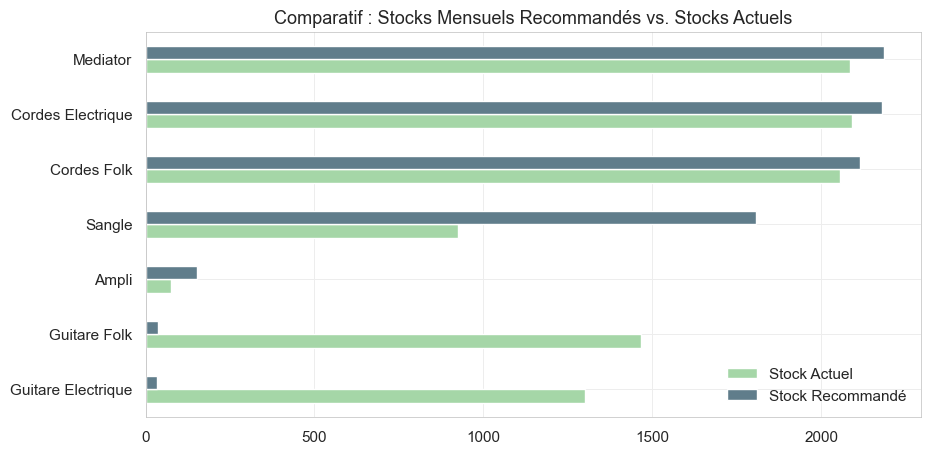

In [43]:
# --- Définition et Application de la Palette de Couleurs ---
# Définition d'une palette de couleurs pour distinguer visuellement les stocks actuels  des stocks recommandés.
PALETTE_INVERSE = {'Stock Actuel': MINI_GREEN, 'Stock Recommandé': MINI_BLUE}

# --- Tracé du Graphique en Barres Horizontales Groupées ---
# Utilisation de 'barh' (barres horizontales) pour visualiser la comparaison des stocks.
df_stocks_comparatifs.plot(kind='barh', figsize=(10, 5), color=PALETTE_INVERSE)

# --- Configuration du Titre et des Axes ---
# Définition du titre du graphique pour contextualiser l'analyse (Actuel vs. Recommandé).
plt.title('Comparatif : Stocks Mensuels Recommandés vs. Stocks Actuels', fontsize=13)

# Suppression de l'étiquette de l'axe Y, les noms des catégories étant déjà clairs.
plt.ylabel('')

# Affichage du graphique.
plt.show()